#Pares da Permutação


In [ ]:
""".alter 2
.param wpmos = 70n
.param wnmos = 70n


.alter 3
.param wnmos = 140n
.param wpmos = 140n


.alter 4
.param wpmos = 210n
.param wnmos = 70n

.alter 5
.param wpmos = 210n
.param wnmos = 140n

.alter 6
.param wpmos = 280n
.param wnmos = 70n

.alter 7
.param wpmos = 280n
.param wnmos = 140n

.alter 8
.param wpmos = 340n
.param wnmos = 70n

.alter 9
.param wpmos = 340n
.param wnmos = 140n

.alter 10
.param wpmos = 340n
.param wnmos = 210n

.alter 11
.param wpmos = 420n
.param wnmos = 140n

.alter 12
.param wpmos = 420n
.param wnmos = 210n
"""

'.alter 2\n.param wpmos = 70n\n.param wnmos = 70n\n\n\n.alter 3\n.param wnmos = 140n\n.param wpmos = 140n\n\n\n.alter 4\n.param wpmos = 210n\n.param wnmos = 70n\n\n.alter 5\n.param wpmos = 210n\n.param wnmos = 140n\n\n.alter 6\n.param wpmos = 280n\n.param wnmos = 70n\n\n.alter 7\n.param wpmos = 280n\n.param wnmos = 140n\n\n.alter 8\n.param wpmos = 340n\n.param wnmos = 70n\n\n.alter 9\n.param wpmos = 340n\n.param wnmos = 140n\n\n.alter 10\n.param wpmos = 340n\n.param wnmos = 210n\n\n.alter 11\n.param wpmos = 420n\n.param wnmos = 140n\n\n.alter 12\n.param wpmos = 420n\n.param wnmos = 210n\n'

#Recap

Anteriormente treinamos quatro algoritmos para três variáveis alvo diferentes. Tivemos bons resultados para alguns, piores para outros, mas no geral conseguimos averiguar que Machine Learning pode servir para prever resultados de simulações elétricas. Dessa vez queremos treinar algoritmos mais avançados que nos retornem multi outputs, com uma variação maior de valores nas variáveis explicativas. Os valores a serem permutados nos dados da simulação Monte Carlo (hspice) de um circuito inversor serão:

* PMOS Width (nm): 70, 140, 210, 280, 340 e 420 
* NMOS Width (nm): 70, 140, 210
* PMOS e NMOS Length (nm): 32 e 40
* Voltage (V): 0.6, 0.7, 0.8 e 0.9
* Temperature (°C): -25, 0 25, 50, 75 e 100

Os nossos algoritmos precisam prever em um output (preferencialmente) as variáveis de energia, atraso de subida e atraso de descida (`ìint`, `tplh` e `tphl`respectivamente). **Não irei trabalhar com regressores lineares dessa vez**. Alguns algoritmos que tenho em mente:
   

*   Uma ou duas arquiteturas de Rede Neural
*   SVR com um kernel polinomial ou similar
*   RandomForest
*   MultiOutputEstimator para os últimos dois



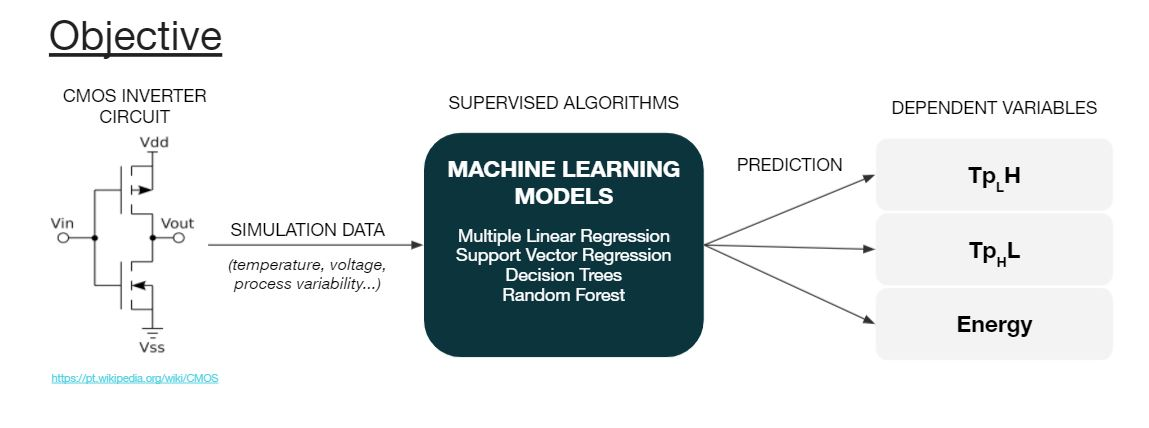

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ajustando o .csv

In [6]:
data = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/simu1/joined_data.csv')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576000 entries, 0 to 575999
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   index      576000 non-null  int64  
 1   nmos@var   576000 non-null  float64
 2   pmos@varp  576000 non-null  float64
 3   tphl       576000 non-null  float64
 4   tplh       576000 non-null  float64
 5   iint       576000 non-null  float64
 6   temper     576000 non-null  float64
 7   alter#     576000 non-null  int64  
 8   tensao     576000 non-null  float64
 9   length     576000 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 43.9 MB


In [9]:
data = data.rename(columns={'alter#': 'alter', 'tensao': 'voltage'})

In [10]:
data.loc[data.alter == 1, ['width_pmos', 'width_nmos']] = 140e-9, 70e-9
data.loc[data.alter == 2, ['width_pmos', 'width_nmos']] = 70e-9, 70e-9 
data.loc[data.alter == 3, ['width_pmos', 'width_nmos']] = 140e-9, 140e-9
data.loc[data.alter == 4, ['width_pmos', 'width_nmos']] = 210e-9, 70e-9
data.loc[data.alter == 5, ['width_pmos', 'width_nmos']] = 210e-9, 140e-9
data.loc[data.alter == 6, ['width_pmos', 'width_nmos']] = 280e-9, 70e-9
data.loc[data.alter == 7, ['width_pmos', 'width_nmos']] = 280e-9, 140e-9
data.loc[data.alter == 8, ['width_pmos', 'width_nmos']] = 340e-9, 70e-9
data.loc[data.alter == 9, ['width_pmos', 'width_nmos']] = 340e-9, 140e-9
data.loc[data.alter == 10, ['width_pmos', 'width_nmos']] = 340e-9, 210e-9
data.loc[data.alter == 11, ['width_pmos', 'width_nmos']] = 420e-9, 140e-9
data.loc[data.alter == 12, ['width_pmos', 'width_nmos']] = 420e-9, 210e-9
data.head()

,index,nmos@var,pmos@varp,tphl,tplh,iint,temper,alter,voltage,length,width_pmos,width_nmos
0,1,0.5166,-0.4341,1.873000e-11,1.832000e-11,-7.727000e-16,-25.0,1,0.6,3.200000e-08,1.400000e-07,7.000000e-08
1,2,0.5064,-0.4523,1.789000e-11,1.983000e-11,-7.881000e-16,-25.0,1,0.6,3.200000e-08,1.400000e-07,7.000000e-08
2,3,0.4909,-0.4618,1.673000e-11,2.086000e-11,-7.808000e-16,-25.0,1,0.6,3.200000e-08,1.400000e-07,7.000000e-08
3,4,0.4882,-0.4667,1.655000e-11,2.135000e-11,-7.832000e-16,-25.0,1,0.6,3.200000e-08,1.400000e-07,7.000000e-08
4,5,0.5275,-0.4342,1.970000e-11,1.834000e-11,-7.699000e-16,-25.0,1,0.6,3.200000e-08,1.400000e-07,7.000000e-08


In [11]:
data = data.drop('alter',axis=1)
data = data.drop('index',axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576000 entries, 0 to 575999
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   nmos@var    576000 non-null  float64
 1   pmos@varp   576000 non-null  float64
 2   tphl        576000 non-null  float64
 3   tplh        576000 non-null  float64
 4   iint        576000 non-null  float64
 5   temper      576000 non-null  float64
 6   voltage     576000 non-null  float64
 7   length      576000 non-null  float64
 8   width_pmos  576000 non-null  float64
 9   width_nmos  576000 non-null  float64
dtypes: float64(10)
memory usage: 43.9 MB


In [13]:
#data = data.apply(pd.to_numeric, errors='coerce')
data.isna().sum()

nmos@var      0
pmos@varp     0
tphl          0
tplh          0
iint          0
temper        0
voltage       0
length        0
width_pmos    0
width_nmos    0
dtype: int64

In [14]:
#data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576000 entries, 0 to 575999
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   nmos@var    576000 non-null  float64
 1   pmos@varp   576000 non-null  float64
 2   tphl        576000 non-null  float64
 3   tplh        576000 non-null  float64
 4   iint        576000 non-null  float64
 5   temper      576000 non-null  float64
 6   voltage     576000 non-null  float64
 7   length      576000 non-null  float64
 8   width_pmos  576000 non-null  float64
 9   width_nmos  576000 non-null  float64
dtypes: float64(10)
memory usage: 43.9 MB


In [15]:
data.to_csv('treated_data.csv') 
!cp treated_data.csv "/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data" #copiar para o drive!

#Limpando e Explorando os Dados

In [16]:
df = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/simu1/treated_data.csv', index_col='Unnamed: 0')

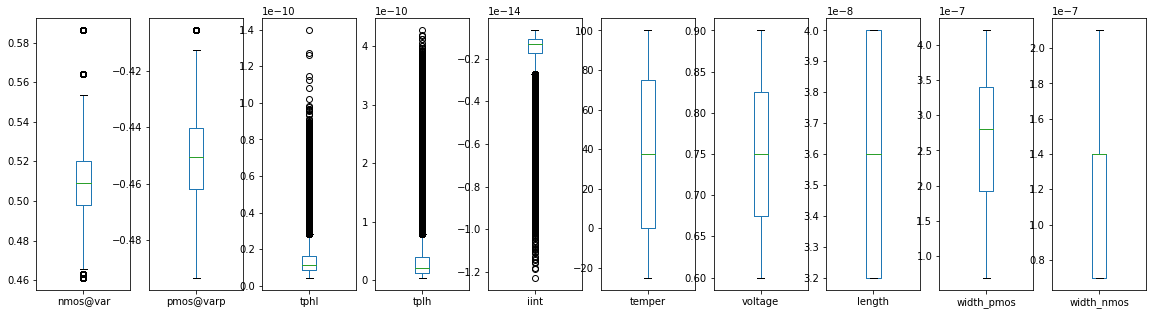

<Figure size 432x288 with 0 Axes>

In [17]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
_ = plt.figure()
plt.show()

Hmm, ```tphl```, ```tplh```, ```iint```, ```width_nmos``` e ```length``` estão com uma distribuição bizarra. Muitos ouliers para os três primeiros. Agora para os dois últimos não entendo, eu que criei essas colunas... Vamos ver as quantidades então 

In [18]:
df.describe()

,nmos@var,pmos@varp,tphl,tplh,iint,temper,voltage,length,width_pmos,width_nmos
count,576000.000000,576000.000000,5.760000e+05,5.760000e+05,5.760000e+05,576000.000000,576000.000000,5.760000e+05,5.760000e+05,5.760000e+05
mean,0.509033,-0.450689,1.411136e-11,3.199148e-11,-1.612343e-15,37.500000,0.750000,3.600000e-08,2.658333e-07,1.225000e-07
std,0.016785,0.015277,8.440719e-12,3.459376e-11,9.355345e-16,42.695665,0.111803,4.000003e-09,1.082789e-07,5.051819e-08
min,0.461300,-0.493300,4.542000e-12,4.125000e-12,-1.226000e-14,-25.000000,0.600000,3.200000e-08,7.000000e-08,7.000000e-08
25%,0.497775,-0.461900,8.612000e-12,1.208000e-11,-1.731000e-15,0.000000,0.675000,3.200000e-08,1.925000e-07,7.000000e-08
50%,0.508850,-0.450500,1.165000e-11,2.054000e-11,-1.318000e-15,37.500000,0.750000,3.600000e-08,2.800000e-07,1.400000e-07
75%,0.520125,-0.440300,1.641000e-11,3.888000e-11,-1.070000e-15,75.000000,0.825000,4.000000e-08,3.400000e-07,1.400000e-07
max,0.586100,-0.405800,1.396000e-10,4.273000e-10,-6.789000e-16,100.000000,0.900000,4.000000e-08,4.200000e-07,2.100000e-07


In [19]:
df['width_nmos'].value_counts()

1.400000e-07    240000
7.000000e-08    240000
2.100000e-07     96000
Name: width_nmos, dtype: int64

In [20]:
df['width_pmos'].value_counts()

3.400000e-07    144000
1.400000e-07     96000
2.100000e-07     96000
4.200000e-07     96000
2.800000e-07     96000
7.000000e-08     48000
Name: width_pmos, dtype: int64

In [21]:
df['temper'].value_counts()

 100.0    96000
-25.0     96000
 75.0     96000
 50.0     96000
 25.0     96000
 0.0      96000
Name: temper, dtype: int64

Ah sim, faz sentido, não variamos tanto esses quanto o ```width_nmos```, então eles tem que ficar naquela faixa mesmo. Agora os atrasos e a energia possuem muito outliers. Vou começar a remover pelos atrasos, ele está mais fácil de discernir do que a energia, depois cuido dessa.

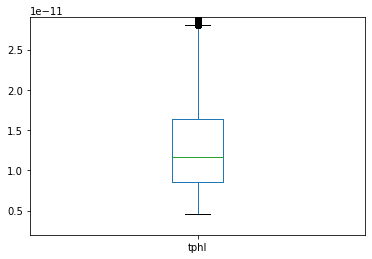

In [22]:
df['tphl'].plot(kind='box')
plt.ylim(2e-12, 2.9e-11)
plt.show()

In [23]:
df = df[(2e-12<=df.tphl)&(df.tphl<=2.9e-11)] #filtrando para deixar no intervalo acima

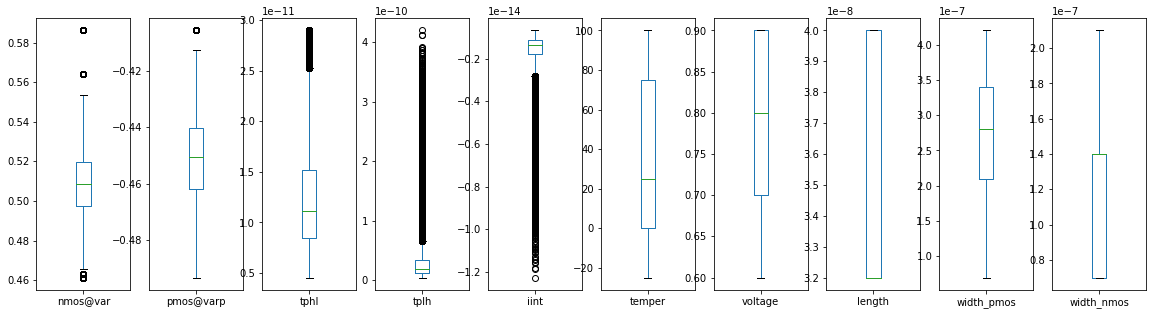

<Figure size 432x288 with 0 Axes>

In [24]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

O ```tphl``` parece ter funcionado, mas ainda estamos com bastante outliers no ```tplh``` e por mais que o ```iint``` tenha reduzido aparentemente, ainda precisa de ajuste. Vamos mexer no ```tplh```

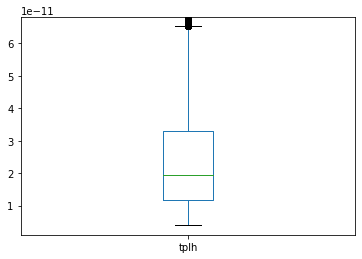

In [25]:
df['tplh'].plot(kind='box')
plt.ylim(1e-12, 6.8e-11)
plt.show()

In [26]:
df = df[(1e-12<=df.tplh)&(df.tplh<=6.8e-11)]

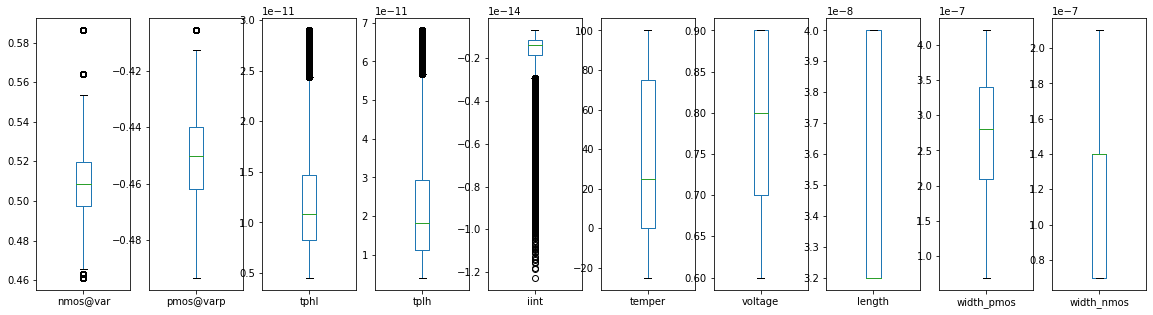

<Figure size 432x288 with 0 Axes>

In [27]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

Melhorou bastante, mas o ```iint``` possui muito outliers ainda. Aparentemente o ```length_n&p = 20e-9```  é que estava gerando esses valores extremos...

(-3e-15, -3e-16)


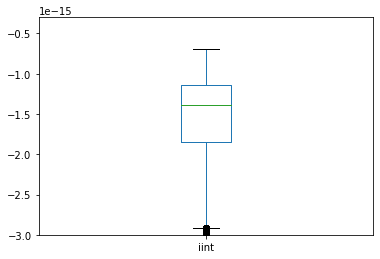

In [28]:
df.iint.plot(kind='box')
print(plt.ylim(-3e-15,-3e-16))
plt.show()

In [29]:
df = df[(-3e-15<=df.iint)]

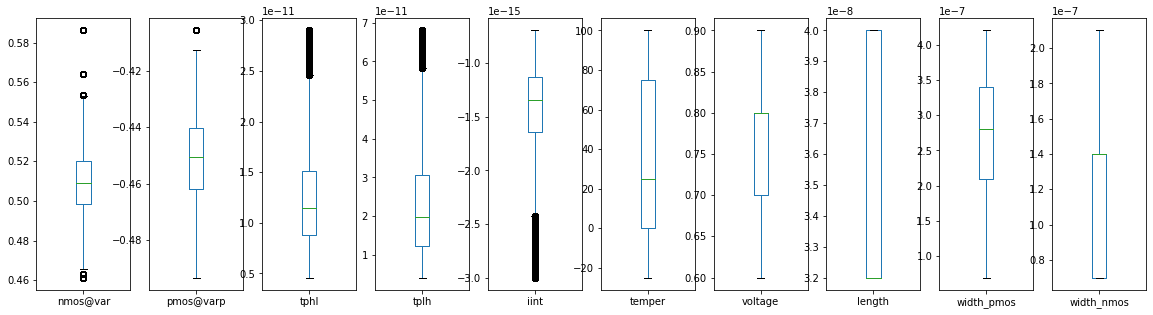

<Figure size 432x288 with 0 Axes>

In [30]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
plt.figure()
plt.show()

Bem melhor sinceramente. Vamos ver o quanto nos sobrou das 576.000 observações

In [31]:
df.describe()
print(576000-459842, (116158/576000)*100)

116158 20.166319444444444


116.158 outliers! Representa 20% dos dados. Vamos checar a porcentagem de perda para cada valor das variáveis explicativas

In [32]:
((data['width_nmos'].value_counts() - df['width_nmos'].value_counts())/data['width_nmos'].value_counts().sum())*100

7.000000e-08    8.192188
1.400000e-07    8.924479
2.100000e-07    3.049653
Name: width_nmos, dtype: float64

In [33]:
((data['width_pmos'].value_counts() - df['width_pmos'].value_counts())/data['width_pmos'].value_counts().sum())*100

7.000000e-08    2.948437
1.400000e-07    5.067882
2.100000e-07    2.264931
2.800000e-07    2.419792
3.400000e-07    4.220313
4.200000e-07    3.244965
Name: width_pmos, dtype: float64

In [34]:
((data['length'].value_counts() - df['length'].value_counts())/data['length'].value_counts().sum())*100

3.200000e-08     8.614931
4.000000e-08    11.551389
Name: length, dtype: float64

In [35]:
((data['temper'].value_counts() - df['temper'].value_counts())/data['temper'].value_counts().sum())*100

-25.0     0.541667
 0.0      1.042882
 25.0     2.091667
 50.0     3.804340
 75.0     5.625868
 100.0    7.059896
Name: temper, dtype: float64

## Correlações

###Visualizações (demoram muito para rodar! >1h Cuidado)

In [36]:
#pd.plotting.scatter_matrix(df, figsize=(10,10))
#plt.figure()
#plt.show()

In [37]:
#_ = sns.pairplot(df, hue="width_nmos", height=2, diag_kind="kde")
#plt.show()

In [38]:
_ = sns.pairplot(df, hue="length", height=2, diag_kind="kde")
plt.show()

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4fef269dd0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f4fef271440> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
_ = sns.pairplot(df, hue="temper", height=2, diag_kind="kde")
plt.show()

###Pearson

In [ ]:
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(df.corr(), mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.show();

###Kendall

In [ ]:
kendall = df.corr(method='kendall')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(kendall, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(kendall, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.show();

###Spearman

In [ ]:
spearman = df.corr(method='spearman')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(spearman, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(spearman, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.show();

#Train, Validation, Test Sets

Apenas testando para o Atraso de Descida

In [56]:
X = df.drop(columns=['tphl', 'tplh', 'iint'])
y = df[['tphl']]

print(X.shape)
print(y.shape)

(459842, 7)
(459842, 1)


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

#Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=seed, test_size=0.25)

# grellert esse é o mais recomendado
#scaler = StandardScaler().fit(Xtr)
#Xtr_sc = scaler.transform(Xtr)
#Xte_sc = scaler.transform(Xte)

In [58]:
from sklearn.model_selection import train_test_split

seed = 23
#X_scal_training, X_scal_test, y_scal_training, y_scal_test = train_test_split(X_scaled, y_scaled, random_state=seed, test_size=0.25)
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (114961, 7)
Test set y (114961, 1)


In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                                                  test_size=0.33) 

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Train set X (231070, 7)
Train set y (231070, 1)
Validation set X (113811, 7)
Validation set y (113811, 1)


#New Models


##SVR

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
params = {'gamma': [0.01, .1, 1,  5,],
          'C': [.001, 1, 100]}

SVR_model_cv_gs = SVR(kernel='rbf')

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(SVR_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_scal_training, y_scal_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
SVR_model_cv_gs = SVR(kernel='rbf', random_state = seed)

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""
                           
# treinando um modelo com a melhor combinação de hiperparâmetros
SVR_model_cv_gs.fit(X_scal_training, y_scal_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [ ]:
y_scal_pred = SVR_model_cv_gs.predict(X_scal_test)

In [ ]:
print(np.concatenate((y_scal_pred.reshape(len(y_scal_pred),3), y_scal_test.reshape(len(y_scal_test),3)), axis=1))

#Results

In [ ]:
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
def generate_model_scores_df(score,y_pred,model_name,new_df=True,df=None):
  if new_df:
    result = pd.DataFrame(columns=['TPHL', 'TPLH', 'IINT'], index=[model_name])
  else:
    result = df
  result.loc[model_name] = score(y_val, y_pred, multioutput='raw_values')
  return result

In [ ]:
sim_0 = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/results_sim0.csv')

In [ ]:
#regre = mean_absolute_error(y_val, y_p, multioutput='raw_values')
randf1 = mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')
#randf2 = mean_absolute_error(y_val, y_pred_2, multioutput='raw_values')
NN = mean_absolute_error(y_val,y_pred, multioutput='raw_values')
#NN2 = mean_absolute_error(y_val,yhat, multioutput='raw_values')

In [ ]:
metricas = pd.DataFrame([randf1,NN],index=['Floresta','MLP'],columns=['tphl','tplh','iint'])

In [ ]:
metricas

,tphl,tplh,iint
Floresta,3.846058e-12,1.137435e-11,3.628414e-16
MLP,3.030069e-04,8.922528e-05,9.800367e-05


#Old Models

##Neural Net #0 (Try hard mode)

In [40]:
import tensorflow as tf

In [41]:
ann = tf.keras.models.Sequential()

Vou fazer apenas um output inicialmente (tphl, coluna 0) para ver como performa, abaixo é o código para a arquitetura e compilação com backpropagation. Vou fazer sem padronizar os dados de treinamento inicialmente

In [42]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [43]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
validation_tphl = y_val[:,0]
train_tphl = y_train[:,0]
test_tphl = y_test[:,0]

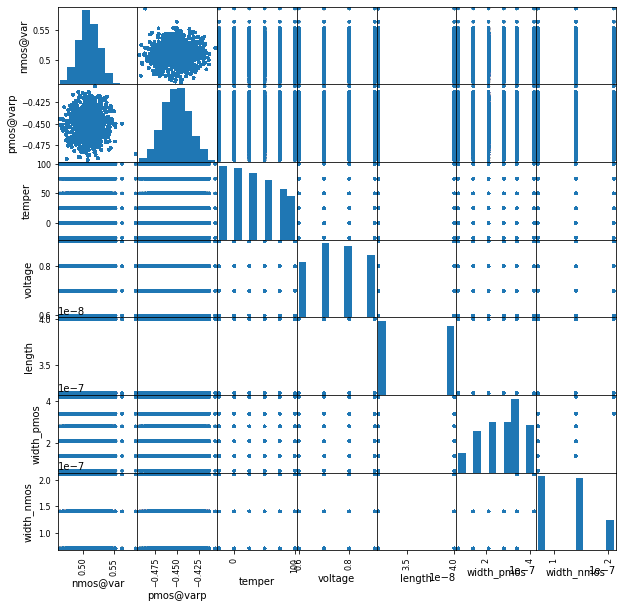

<Figure size 432x288 with 0 Axes>

In [60]:
pd.plotting.scatter_matrix(X_train, figsize=(10,10))
plt.figure()
plt.show()

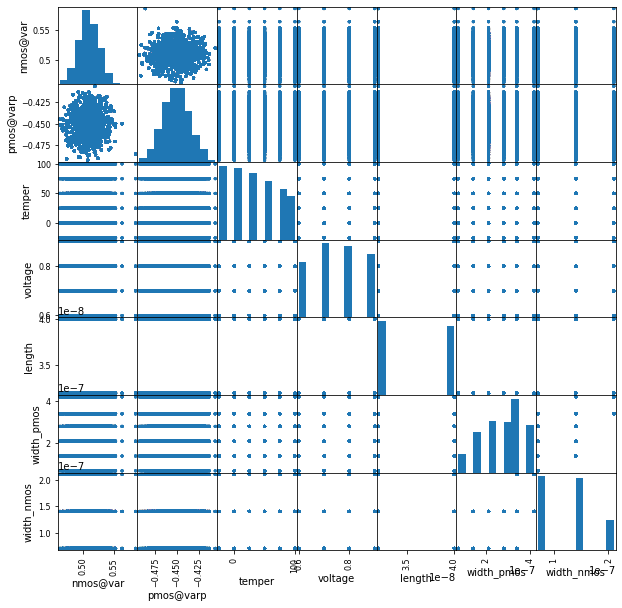

<Figure size 432x288 with 0 Axes>

In [61]:
pd.plotting.scatter_matrix(X_val, figsize=(10,10))
plt.figure()
plt.show()

[]

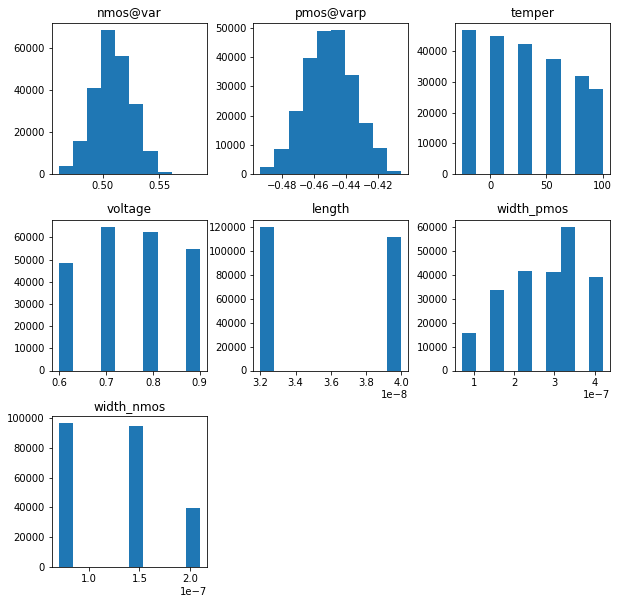

In [78]:
X_train.hist(grid=False, figsize=(10,10))
plt.title("DATASET: TREINO")
plt.plot()

[]

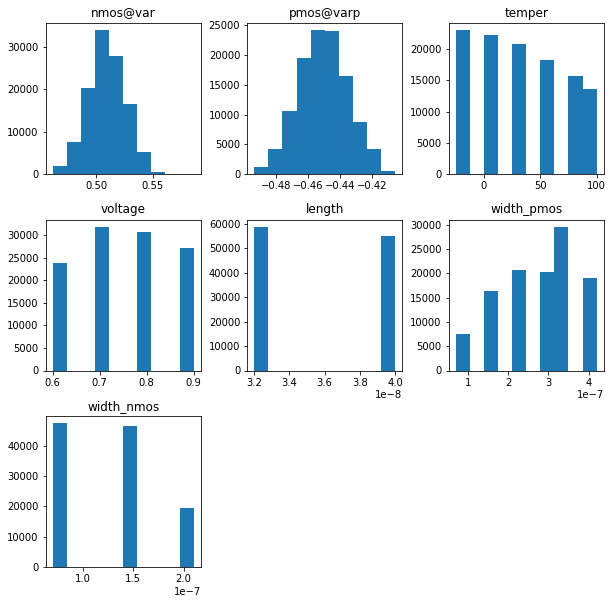

In [79]:
X_val.hist(grid=False, figsize=(10,10))
plt.title("DATASET: VALIDAÇÃO")
plt.plot()

Bruh, o loss diminuiu bastante e até convergiu no epoch 6, mas as predições estão constantes... wtf? Tentarei normalizar, vamos ver se altera algo, se não é mexer na arquitetura pq o modelo não está aprendendo. Aparentemente o sem alterar os dados convergiu no 30 epoch tmb. Scheisse. A normalização ainda converge, porém os resultados constantes são mais próximos da escala esperada. Vou trabalhar com ela e ver se altero a arquitetura e outros parãmetros como o batch size. O batch size e as units não me parecem trazer alterações relevantes. Vou adicionar mais Layers na esperança de a ann aprender algo a mais, minha última alternativa é alterar a composição do dataset. O aumento para 4 layers com 12 units piorou os resultados

In [ ]:
from sklearn.preprocessing import normalize

X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)

In [ ]:
ann.fit(X_train_norm,train_tphl, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 8s 1ms/step - loss: 6.7028e-06
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.0959e-08
Epoch 3/50
5777/5777 [==============================] - 8s 1ms/step - loss: 4.3647e-08
Epoch 4/50
5777/5777 [==============================] - 8s 1ms/step - loss: 2.2463e-08
Epoch 5/50
5777/5777 [==============================] - 8s 1ms/step - loss: 2.2626e-08
Epoch 6/50
5777/5777 [==============================] - 8s 1ms/step - loss: 1.4240e-08
Epoch 7/50
5777/5777 [==============================] - 8s 1ms/step - loss: 1.1487e-08
Epoch 8/50
5777/5777 [==============================] - 8s 1ms/step - loss: 1.0302e-08
Epoch 9/50
5777/5777 [==============================] - 8s 1ms/step - loss: 8.4223e-09
Epoch 10/50
5777/5777 [==============================] - 8s 1ms/step - loss: 7.1264e-09
Epoch 11/50
5777/5777 [==============================] - 8s 1ms/step - loss: 5.3624e-09
Epoch 12/50
5777/5777 [==================

In [ ]:
y_pred_nn0 = ann.predict(X_val_norm)
#np.set_printoptions(precision=2)
print(np.concatenate((y_pred_nn0.reshape(len(y_pred_nn0),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[2.33e-10 9.68e-12]
 [2.33e-10 1.35e-11]
 [2.33e-10 7.57e-12]
 ...
 [2.33e-10 8.69e-12]
 [2.33e-10 1.37e-11]
 [2.33e-10 5.91e-12]]


## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)"""

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_norm, train_tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_norm)

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[-1.35e-04  9.68e-12]
 [ 1.02e-04  1.35e-11]
 [-5.48e-03  7.57e-12]
 ...
 [-1.57e-04  8.69e-12]
 [-1.75e-04  1.37e-11]
 [-1.91e-04  5.91e-12]]


Score on training set: -598198417686226560.000
Score on validation set: -601938109190083200.000
Explained variance score: -6.019363056862876e+17
Mean absolute error (MAE): 0.002912541559344496
Mean squared error (MSE): 1.3897360339482752e-05
R² Score: -601938109190083200.000


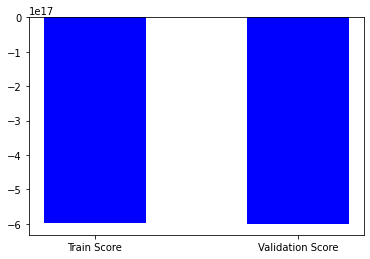

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_norm, train_tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_norm, validation_tphl)))
y = [neural_network_model.score(X_train_norm, train_tphl), 
     neural_network_model.score(X_val_norm, validation_tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {}".format(explained_variance_score(validation_tphl, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(validation_tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(validation_tphl, y_pred)))
print("R² Score: {:.3f}".format(r2_score(validation_tphl, y_pred)))

##Neural Net #2 (Keras with multioutput)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model
  
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = 7, 3
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

TypeError: ignored

In [ ]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction for new data
yhat = model.predict(X_val)
print('Predicted: %s' % yhat[0])

## Random Forest MultiOutput

In [ ]:
##### RandomForest tphl
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_model =  MultiOutputRegressor(RandomForestRegressor(random_state=seed)).fit(X_train, y_train)

y_pred_1 = rf_model.predict(X_val)

In [ ]:
print(np.concatenate((y_pred_1.reshape(len(y_pred_1),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.25e-11  2.34e-11 -1.46e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, y_pred_1, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, y_pred_1, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [5.33e-15 1.89e-15 2.00e-15]
Mean absolute error (MAE): [3.85e-12 1.14e-11 3.63e-16]
Mean squared error (MSE): [2.31e-23 2.03e-22 2.25e-31]


In [ ]:
from sklearn.model_selection import GridSearchCV
"""
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 7],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) """

'\nparams = {\'n_estimators\': [5, 50, 100, 500],\n          \'max_features\': [2, 5, 7],\n          \'max_depth\': [2, 5, 10, 50],\n          \'min_samples_split\': [2, 8, 15, 30],}\n\n# criando o objeto do modelo com RandomForestRegressor\nrf_model_cv_gs = RandomForestRegressor(random_state = seed)\n\n# criando o objeto do grid search com GridSearchCV\ngrid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3\n\n# treinando o modelo com o grid search\ngrid_search.fit(X_training, y_training)\n\n# imprimindo a melhor combinação de hiperparâmetros\nprint(\'\n Best hyperparameters:\')\nprint(grid_search.best_params_)\n\n# pegando os resultados da validação cruzada (cv_results)\ncv_results = pd.DataFrame(grid_search.cv_results_)\n\n# imprimindo o score médio nas bases de treino\nprint("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],\n                  

In [ ]:
"""Best hyperparameters:
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
Average Score on train set: -0.000 +/- 0.000
Average Score on validation set: -0.000 +/- 0.000"""

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""

rf_model_cv_gs = RandomForestRegressor(random_state = seed)

rf_model_cv_gs.set_params(n_estimators = 100,
                           max_features = 2,
                           max_depth = 2,
                           min_samples_split = 2)
# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalize(X_training), y_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [ ]:
pred = rf_model_cv_gs.predict(normalize(X_test))
print(np.concatenate((pred.reshape(len(pred),3), y_test.reshape(len(y_test),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  6.59e-12  7.30e-12 -2.95e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.78e-12  5.21e-12 -1.90e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  9.29e-12  1.76e-11 -1.44e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.86e-12  1.34e-11 -1.41e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.53e-11  2.20e-11 -1.52e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.49e-12  5.95e-12 -1.60e-15]]


##SVR Polynomial MultiOutput


In [ ]:
from sklearn.svm import SVR
SVR = MultiOutputRegressor(SVR(kernel = 'linear')).fit(normalize(X_train), y_train) # kernel='rbf', C, gamma
svr_pred = SVR.predict(normalize(X_val))

In [ ]:
print(np.concatenate((svr_pred.reshape(len(svr_pred),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.68e-11  3.61e-11 -1.85e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.68e-11  3.61e-11 -1.85e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.68e-11  3.61e-11 -1.85e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, svr_pred, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, svr_pred, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, svr_pred, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [ 5.44e-15  1.89e-15 -6.66e-16]
Mean absolute error (MAE): [5.68e-12 1.71e-11 5.51e-16]
Mean squared error (MSE): [4.19e-23 3.64e-22 3.75e-31]
